## Function Definitions

In [1]:
import geopandas as gpd
import pickle
import numpy as np
import glob
import os
import sys
from copy import deepcopy
import scipy.stats
import pandas as pd

from climada.util import coordinates as u_coords

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

In [2]:
def load_dict(path_dict):
    # load any dict saved as pkl
    with open(path_dict, 'rb') as stats_dict:
         stats_dict = pickle.load(stats_dict)
    return stats_dict

def save_dict(dict_var, save_path):
    # save any dict as pkl
    with open(save_path, 'wb') as f:
        pickle.dump(dict_var, f)


## Creating Impact Cascade Factors

### Cascade Factor A & B

In [ ]:
haz_type='TC'
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps = load_dict(path_cntry_folder+f'total_service_disruptions_{iso3}_{haz_type}.pkl')
    total_imps_rela = {key : total_imps[key]/total_imps['people'] for key in total_imps.keys()}
    save_dict(total_imps_rela, path_cntry_folder+f'total_service_disruptions_rela_{iso3}_{haz_type}.pkl')

    total_imps_relb={}
    def service_dict2():
        return {'actual_supply_power_line_people' : 'electricity',
           'actual_supply_celltower_people' : 'mobile communications',
           'actual_supply_health_people': 'healthcare',
           'actual_supply_education_people' : 'education',
           'actual_supply_road_people' : 'mobility'}
    
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        sub_gdf = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & (gdf_summed_popweighted[variable]<0)]
        lost_service_while_aff = np.maximum(sub_gdf[variable], sub_gdf['imp_dir']).sum()
        total_imps_relb[service] = np.round(lost_service/lost_service_while_aff,2)
    total_imps_relb['people']=1
    save_dict(total_imps_relb, path_cntry_folder+f'total_service_disruptions_relb_{iso3}_{haz_type}.pkl')
                                              

In [ ]:
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps = load_dict(path_cntry_folder+f'{state}/total_service_disruptions_{iso3}_{haz_type}_{state}.pkl')
    total_imps_rela = {key : total_imps[key]/total_imps['people'] for key in total_imps.keys()}
    save_dict(total_imps_rela, path_cntry_folder+f'{state}/total_service_disruptions_rela_{iso3}_{state}_{haz_type}.pkl')

    total_imps_relb={}
    def service_dict2():
        return {'actual_supply_power_line_people' : 'electricity',
           'actual_supply_celltower_people' : 'mobile communications',
           'actual_supply_health_people': 'healthcare',
           'actual_supply_education_people' : 'education',
           'actual_supply_road_people' : 'mobility'}
    
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'{state}/summed_pop_impacts_{haz_type}_{iso3}_{state}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        sub_gdf = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & (gdf_summed_popweighted[variable]<0)]
        lost_service_while_aff = np.maximum(sub_gdf[variable], sub_gdf['imp_dir']).sum()
        total_imps_relb[service] = np.round(lost_service/lost_service_while_aff,2)
    total_imps_relb['people']=1
    save_dict(total_imps_relb, path_cntry_folder+f'{state}/total_service_disruptions_relb_{iso3}_{state}_{haz_type}.pkl')

### Cascade Factor C

In [135]:
haz_type='TC'
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'    
    
    total_imps_relc={}
    def service_dict2():
        return {'actual_supply_power_line_people' : 'electricity',
           'actual_supply_celltower_people' : 'mobile communications',
           'actual_supply_health_people': 'healthcare',
           'actual_supply_education_people' : 'education',
           'actual_supply_road_people' : 'mobility'}
    
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        # has or had service, in directly affected area
        had_service_affected = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & 
                                                      (gdf_summed_popweighted[variable]!=0)]['imp_dir'].sum()
        total_imps_relc[service] = np.round(lost_service/had_service_affected,2)
    
    total_imps_relc['people']=1
    save_dict(total_imps_relc, path_cntry_folder+f'total_service_disruptions_relc_{iso3}_{haz_type}.pkl')
                                              

In [136]:
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_relc={}
    def service_dict2():
        return {'actual_supply_power_line_people' : 'electricity',
           'actual_supply_celltower_people' : 'mobile communications',
           'actual_supply_health_people': 'healthcare',
           'actual_supply_education_people' : 'education',
           'actual_supply_road_people' : 'mobility'}
    
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'{state}/summed_pop_impacts_{haz_type}_{iso3}_{state}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        # has or had service, in directly affected area
        had_service_affected = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & 
                                                      (gdf_summed_popweighted[variable]!=0)]['imp_dir'].sum()
        total_imps_relc[service] = np.round(lost_service/had_service_affected,2)
    
    total_imps_relc['people']=1
    save_dict(total_imps_relc, path_cntry_folder+f'{state}/total_service_disruptions_relc_{iso3}_{state}_{haz_type}.pkl')
    

### Loading Impact Cascade Factors

In [137]:
# Comparison 1: Cascading factors
haz_type = 'TC'
total_imps_rela={}
total_imps_relb={}
total_imps_relc={}

for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ',  'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_rela[iso3] = load_dict( path_cntry_folder+f'total_service_disruptions_rela_{iso3}_{haz_type}.pkl')
    total_imps_relb[iso3] = load_dict( path_cntry_folder+f'total_service_disruptions_relb_{iso3}_{haz_type}.pkl')
    total_imps_relc[iso3] = load_dict( path_cntry_folder+f'total_service_disruptions_relc_{iso3}_{haz_type}.pkl')
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_rela[f'{iso3} {state}'] = load_dict(path_cntry_folder+f'{state}/total_service_disruptions_rela_{iso3}_{state}_{haz_type}.pkl')
    total_imps_relb[f'{iso3} {state}'] = load_dict(path_cntry_folder+f'{state}/total_service_disruptions_relb_{iso3}_{state}_{haz_type}.pkl')
    total_imps_relc[f'{iso3} {state}'] = load_dict(path_cntry_folder+f'{state}/total_service_disruptions_relc_{iso3}_{state}_{haz_type}.pkl')


In [138]:
print(total_imps_relb)
print(total_imps_rela)
print(total_imps_relc)


{'ATG': {'electricity': 1.06, 'mobile communications': 1.02, 'healthcare': 1.0, 'education': 1.06, 'mobility': 1.0, 'people': 1}, 'BGD': {'electricity': 1.41, 'mobile communications': 1.24, 'healthcare': 1.17, 'education': 1.36, 'mobility': 1.01, 'people': 1}, 'CUB': {'electricity': 1.28, 'mobile communications': 1.26, 'healthcare': 1.18, 'education': 1.28, 'mobility': 1.0, 'people': 1}, 'GTM': {'electricity': 4.33, 'mobile communications': 4.48, 'healthcare': 3.77, 'education': 4.67, 'mobility': 1.01, 'people': 1}, 'HTI': {'electricity': 4.98, 'mobile communications': 2.78, 'healthcare': 2.24, 'education': 2.94, 'mobility': 1.12, 'people': 1}, 'KHM': {'electricity': 2.46, 'mobile communications': 2.39, 'healthcare': 2.42, 'education': 2.43, 'mobility': 1.14, 'people': 1}, 'LKA': {'electricity': 1.35, 'mobile communications': 1.22, 'healthcare': 1.14, 'education': 1.35, 'mobility': 1.0, 'people': 1}, 'MDG': {'electricity': 1.97, 'mobile communications': 2.27, 'healthcare': 2.2, 'educat

## Overview Plots

In [142]:
def plot_relative_impacts_bars(imp_dict_relb_all, imp_dict_rela_all, imp_dict_relc_all, save_path=None):
    """both in one
    relb - rel to base state availability
    rela - rel to direclty affected
    """ 
    f, axes = plt.subplots(len(imp_dict_relb_all.keys()), 3, figsize=(6, 3*len(imp_dict_relb_all.keys())),
                          sharex=True, sharey=True)
    
    width = 0.8
    x = np.arange(5)
    axes = axes.flatten()
    year_range = '1980-2020' 
    if haz_type=='FL':
        year_range = '2002-2018'
    elif haz_type=='RF':
        year_range = '1971-2005'
            
    i=0
    for out_b, out_a, out_c in zip(imp_dict_relb_all.items(), imp_dict_rela_all.items(), imp_dict_relc_all.items()):
        
        ax1=axes[i]
        ax2=axes[i+1]
        ax3=axes[i+2]
        
        iso3 = out_a[0]
        imp_dict_relb = out_b[1]
        imp_dict_rela = out_a[1]
        imp_dict_relc = out_c[1]
        
        relb_base = imp_dict_relb.pop('people')
        rela_base = imp_dict_rela.pop('people')
        relc_base = imp_dict_relc.pop('people')
        relb_vals = np.round(np.array(list(imp_dict_relb.values())),2)
        rela_vals = np.round(np.array(list(imp_dict_rela.values())),2)
        relc_vals = np.round(np.array(list(imp_dict_relc.values())),2)
        
        labels = imp_dict_relb.keys()

        rects1 = ax1.bar(x, relb_vals, width, color='red', label='rel. to pop. with service loss in dir. affected area')
        ax1.set_ylabel('Impact Factor B')
        ax1.title.set_text(f'{iso3}')
        ax1.set_xticks(x, labels, rotation=45)
        ax1.plot([0.-width/2, 4+width/2], [relb_base, relb_base], "k--", linewidth=2)
        #ax1.legend()
        ax1.bar_label(rects1, padding=3)

        rects2 = ax2.bar(x, rela_vals, width, color='blue', label='rel. to directly affected pop.')
        ax2.set_ylabel('Impact Factor A')
        ax2.set_xticks(x, labels, rotation=45)
        ax2.title.set_text(f'{iso3}')
        ax2.plot([0.-width/2, 4+width/2], [rela_base, rela_base], "k--", linewidth=2)
        #ax2.legend()
        ax2.bar_label(rects2, padding=3)
        
        rects3 = ax3.bar(x, relc_vals, width, color='green', label='rel. to pop. with initial services in dir. affected ar')
        ax3.set_ylabel('Impact Factor C')
        ax3.set_xticks(x, labels, rotation=45)
        ax3.title.set_text(f'{iso3}')
        ax3.plot([0.-width/2, 4+width/2], [relc_base, relc_base], "k--", linewidth=2)
        #ax2.legend()
        ax3.bar_label(rects3, padding=3)
        i+=3
        
    #f.suptitle( f"Average relative service disruptions from {haz_type}, all countries , {year_range}",  fontsize=16)
    #f.tight_layout()
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

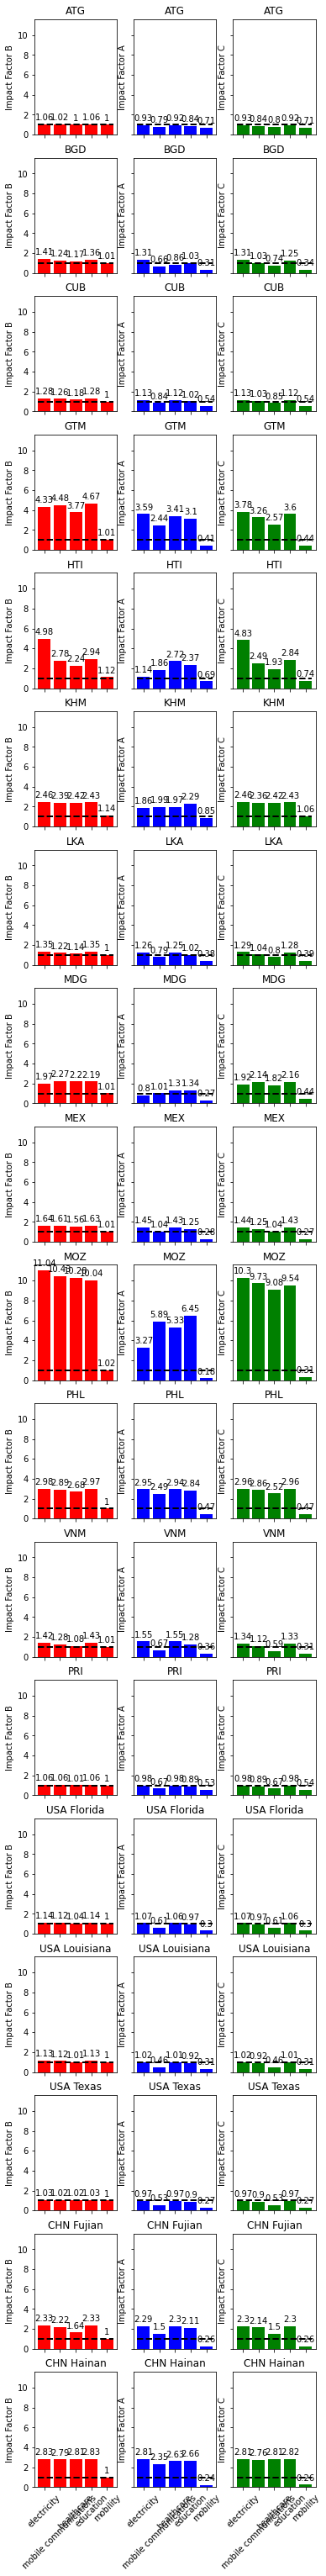

In [143]:
plot_relative_impacts_bars(deepcopy(total_imps_relb), deepcopy(total_imps_rela), deepcopy(total_imps_relc), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_both')

In [9]:
def plot_relative_impacts_bars_2(imp_dict_relb_all, save_path=None):
    """both in one
    relb - rel to base state availability
    rela - rel to direclty affected
    """ 
    f, axes = plt.subplots(int(np.ceil(len(imp_dict_relb_all.keys())/4)), 4, figsize=(10, 20),
                          sharex=True, sharey=True)
    
    width = 0.8
    x = np.arange(5)
    axes = axes.flatten()
    year_range = '1980-2020' 
    if haz_type=='FL':
        year_range = '2002-2018'
    elif haz_type=='RF':
        year_range = '1971-2005'
            
    i=0
    for iso3, imp_dict_relb in imp_dict_relb_all.items():       
        ax1=axes[i]      
        relb_base = imp_dict_relb.pop('people')
        relb_vals = np.round(np.array(list(imp_dict_relb.values())),2)
        labels = imp_dict_relb.keys()

        rects1 = ax1.bar(x, relb_vals, width, color='red', label='rel. to pop. with service access in base state')
        ax1.set_ylabel('Impact Factor')
        ax1.title.set_text(f'{iso3}')
        ax1.set_xticks(x, labels, rotation=90)
        ax1.plot([0.-width/2, 4+width/2], [relb_base, relb_base], "k--", linewidth=2)
        #ax1.legend()
        ax1.bar_label(rects1, padding=3)

        i+=1
    #f.suptitle( f"Average relative service disruptions from {haz_type}, all countries , {year_range}",  fontsize=16)
    #f.tight_layout()
    remainder=(len(imp_dict_relb_all.keys())%4)*-1
    if remainder < 0:
        for ax in axes[remainder:]:
            ax.remove()
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

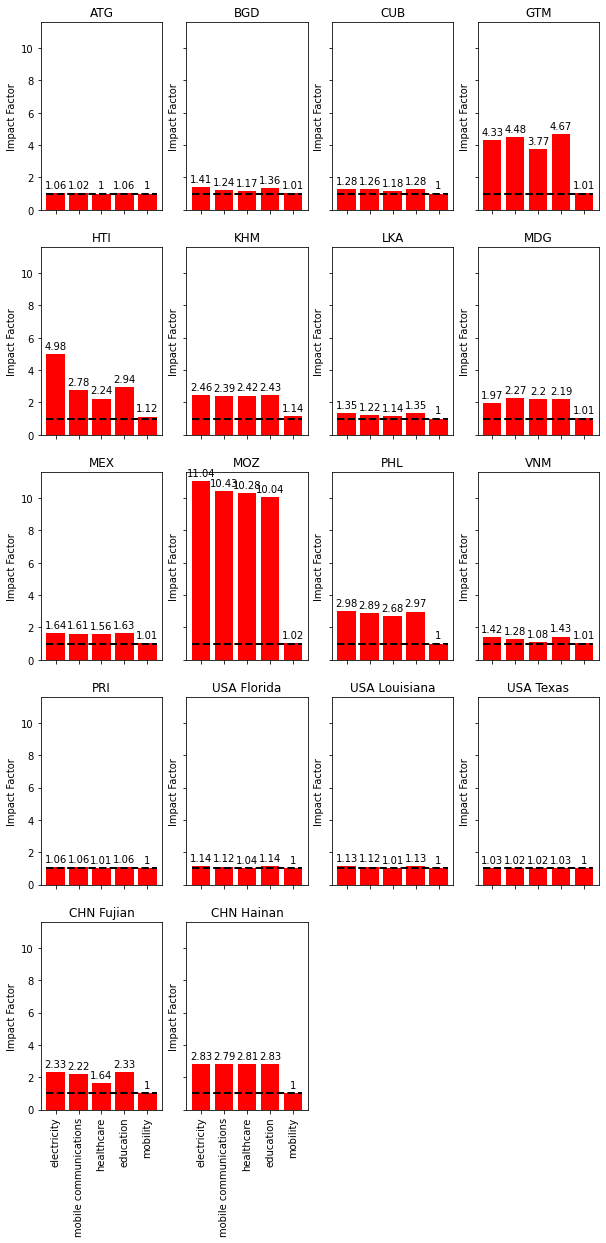

In [127]:
plot_relative_impacts_bars_2(deepcopy(total_imps_relb), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_b')


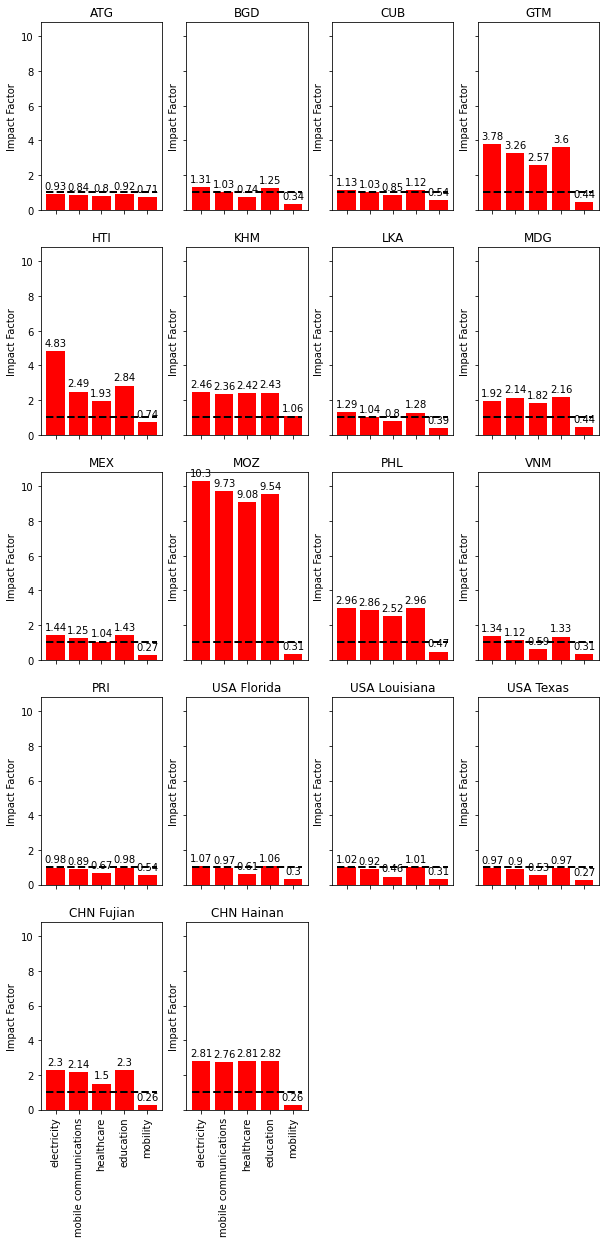

In [144]:
plot_relative_impacts_bars_2(deepcopy(total_imps_relc), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_c')


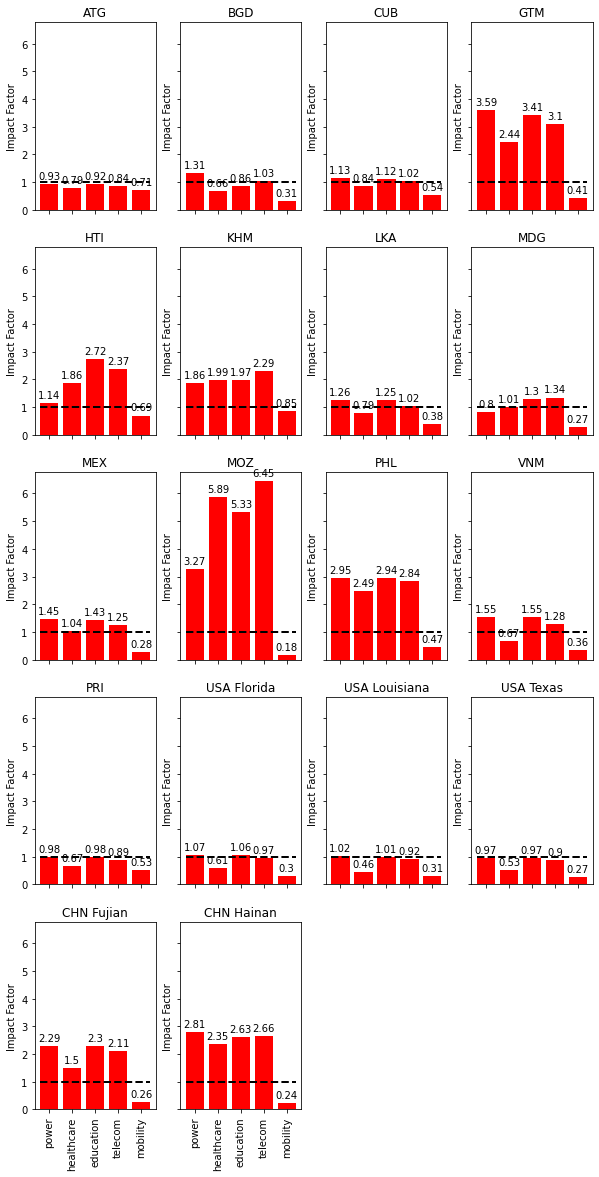

In [128]:
plot_relative_impacts_bars_2(deepcopy(total_imps_rela), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_a')

In [10]:
def inc_class_dict():
    return {'ATG': 1,
 'BGD': 4,
 'CUB': 2,
 'GTM': 2,
 'HTI': 4,
 'KHM': 3,
 'LKA': 3,
 'MDG': 4,
 'MEX': 2,
 'MOZ': 4,
 'PHL': 3,
 'VNM': 3,
 'PRI': 1,
 'USA Florida': 1,
 'USA Louisiana': 1,
 'USA Texas': 1,
 'CHN Fujian': 2,
 'CHN Hainan': 2}

In [11]:
def pop_density_dict():
    return {'ATG': 222,
 'BGD': 1265,
 'CUB': 110,
 'GTM': 167,
 'HTI': 413,
 'KHM': 95,
 'LKA': 354,
 'MDG': 47,
 'MEX': 66,
 'MOZ': 39,
 'PHL': 367,
 'VNM': 313,
 'PRI': 360,
 'USA Florida': 136,
 'USA Louisiana': 41,
 'USA Texas': 43,
 'CHN Fujian': 350,
 'CHN Hainan': 276}

In [29]:
dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))

{'electricity': [],
 'mobile communications': [],
 'healthcare': [],
 'education': [],
 'mobility': []}

In [13]:
def scatter_cascade_ranking(imp_dict_relb_all, ref_dict, label, save_path=None):
    summary_dict = {}   
    for iso3, imp_dict in imp_dict_relb_all.items():
        imp_dict.pop('people')
        summary_dict[iso3] = np.array(list(imp_dict.values())).sum()/5
    plt.scatter([ref_dict[iso3] for iso3 in summary_dict.keys()], summary_dict.values())
    #plt.xticks(np.arange(5))
    plt.xlabel(label)
    plt.ylabel('Average Cascade factor')
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()
                

In [ ]:
scatter_cascade_ranking_perservice(imp_dict_relb_all, ref_dict, label, save_path=None)

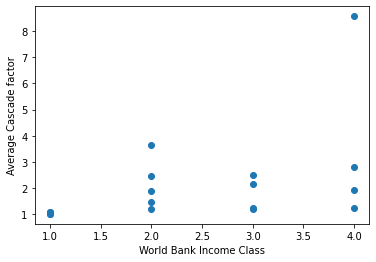

In [14]:
scatter_cascade_ranking(deepcopy(total_imps_relb), inc_class_dict(), label='World Bank Income Class')

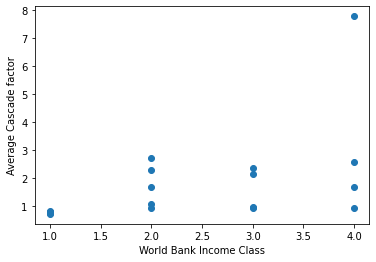

In [145]:
scatter_cascade_ranking(deepcopy(total_imps_relc), inc_class_dict(), label='World Bank Income Class')

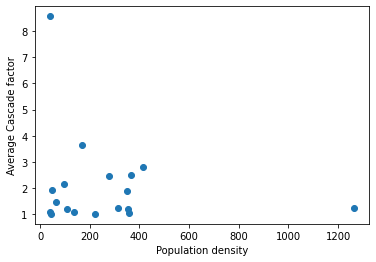

In [15]:
scatter_cascade_ranking(deepcopy(total_imps_relb), pop_density_dict(), label='Population density')

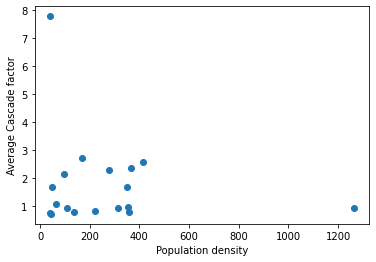

In [146]:
scatter_cascade_ranking(deepcopy(total_imps_relc), pop_density_dict(), label='Population density')

In [31]:
import seaborn as sns
def scatter_cascade_ranking_perservice(imp_dict_relb_all, save_path=None):
    
    f, ax = plt.subplots(1,1, figsize=(10, 10),
                          sharex=True, sharey=True)
    
    summary_dict = dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))  
    for service in summary_dict.keys():
        summary_dict[service] = [cntry_dict[service] for cntry_dict in imp_dict_relb_all.values()]
    summary_df = pd.DataFrame.from_dict(summary_dict)
    sns.catplot(summary_df)
    #plt.xticks(np.arange(5))
    #plt.xlabel(label)
    plt.ylabel('Average Cascade factor')
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

In [36]:
import seaborn as sns
def scatter_cascade_ranking_perservice(imp_dict_relb_all, save_path=None):
    
    summary_dict = dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))  
    for service in summary_dict.keys():
        summary_dict[service] = [cntry_dict[service] for cntry_dict in imp_dict_relb_all.values()]
    summary_df = pd.DataFrame.from_dict(summary_dict)
    print(summary_df)
    sns.catplot(summary_df)

In [147]:
col_list = ['casc_factor_b','casc_factor_c', 'service', 'iso3']
cascade_factors_df = pd.DataFrame(columns=col_list)
for items_b, items_c in zip(total_imps_relb.items(), total_imps_relc.items()):
    cntry_df = pd.DataFrame(columns=col_list)
    cntry_df['casc_factor_b'] = list(items_b[1].values())[:-1]
    cntry_df['casc_factor_c'] = list(items_c[1].values())[:-1]
    cntry_df['service'] = list(cntry_dict.keys())[:-1]
    cntry_df['iso3'] = items_b[0]
    cascade_factors_df = cascade_factors_df.append(cntry_df, ignore_index=True)

In [148]:
cascade_factors_df['WB_inc_class'] = cascade_factors_df.apply(lambda row: inc_class_dict()[row.iso3], axis=1)

In [149]:
cascade_factors_df['pop_density'] = cascade_factors_df.apply(lambda row: pop_density_dict()[row.iso3], axis=1)

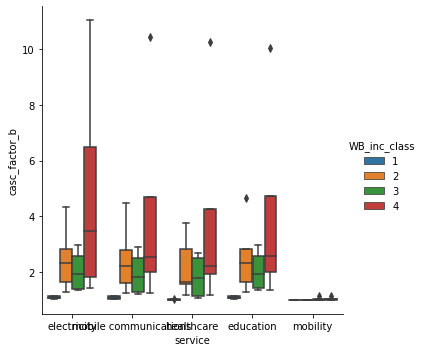

In [150]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_b", kind='box', hue="WB_inc_class")

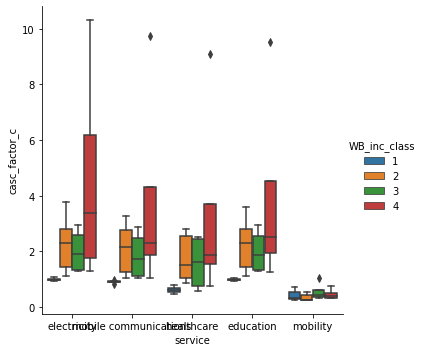

In [151]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_c", kind='box', hue="WB_inc_class")

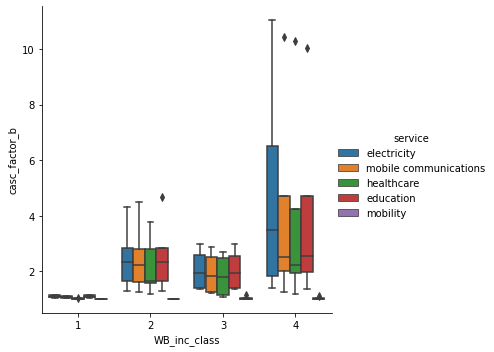

In [152]:
sns.catplot(data=cascade_factors_df, x="WB_inc_class", y="casc_factor_b", kind='box', hue="service")

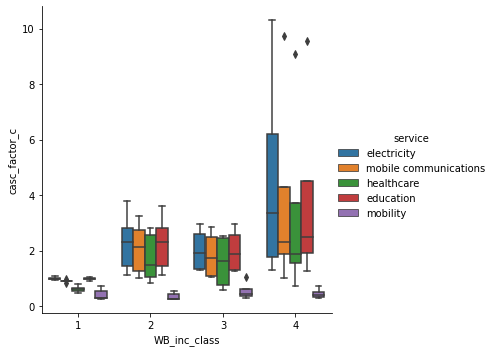

In [153]:
sns.catplot(data=cascade_factors_df, x="WB_inc_class", y="casc_factor_c", kind='box', hue="service")

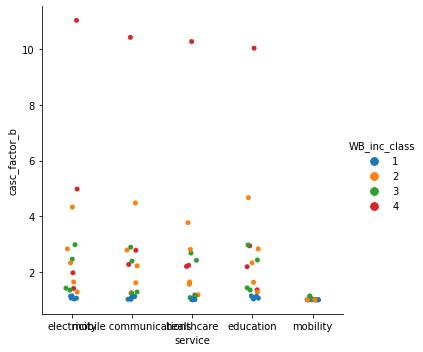

In [154]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_b", hue="WB_inc_class")

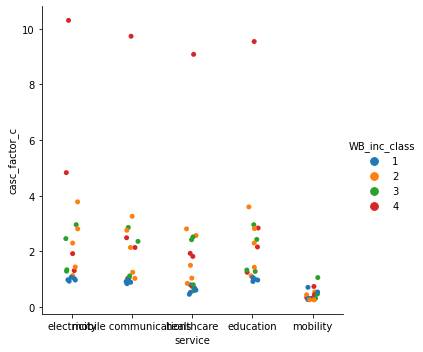

In [155]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_c", hue="WB_inc_class")

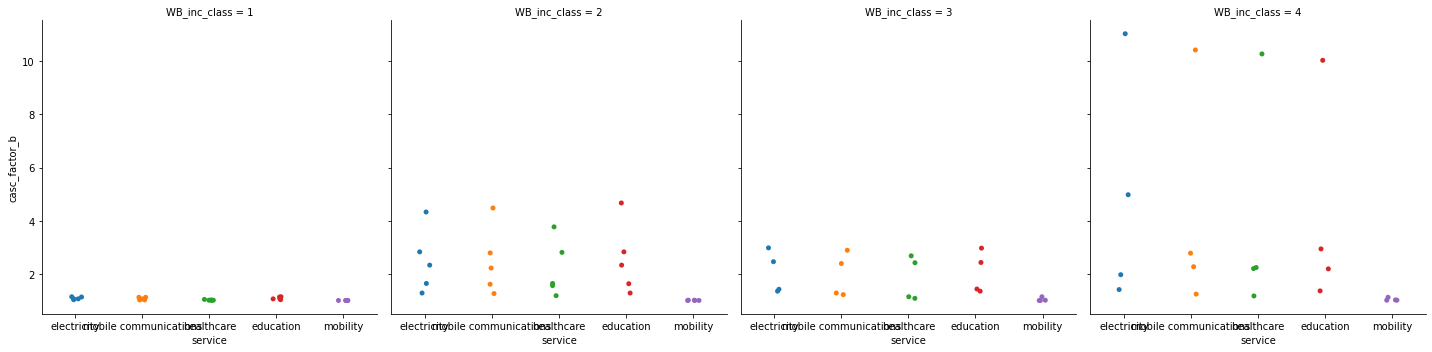

In [159]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_b", col="WB_inc_class")

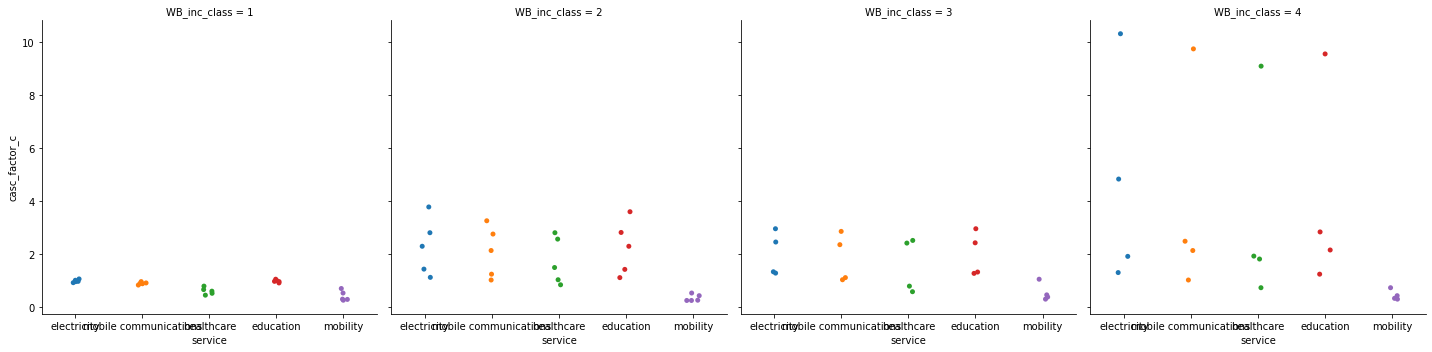

In [158]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_c", col="WB_inc_class")

<AxesSubplot: xlabel='pop_density', ylabel='casc_factor_b'>

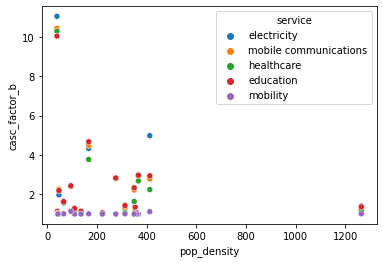

In [156]:
sns.scatterplot(data=cascade_factors_df, x="pop_density", y="casc_factor_b", hue="service")

<AxesSubplot: xlabel='pop_density', ylabel='casc_factor_c'>

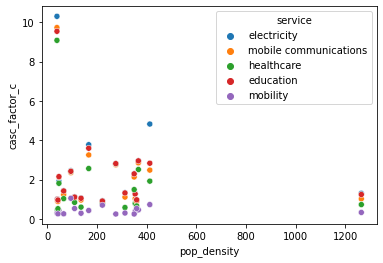

In [157]:
sns.scatterplot(data=cascade_factors_df, x="pop_density", y="casc_factor_c", hue="service")

In [ ]:
def scatter_cascade_ranking_perservice(imp_dict_relb_all, ref_dict, label, save_path=None):
    
    f, axes = plt.subplots(3,2, figsize=(15, 10),
                          sharex=True, sharey=True)
    axes = axes.flatten()
    
    summary_dict = dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))  
    for service in summary_dict.keys():
        summary_dict[service] = [cntry_dict[service] for cntry_dict in imp_dict_relb_all.values()]
    for ax in axes:
        ax.scatter([ref_dict[iso3] for iso3 in summary_dict.keys()], summary_dict.values())
    #plt.xticks(np.arange(5))
    plt.xlabel(label)
    plt.ylabel('Average Cascade factor')
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()